\title{}

\section*{Convex Optimization}
\subsection*{Homework 3 : LASSO}


<b> Student <b/> : Simon Queric 

<b> Question 1 </b>

The lagrangian of the LASSO problem, with change of variable $u = Xw - y$ and dual variable $v$, is 

$$ L(w, u, v) = \frac{1}{2}\|u\|^2_2 + \lambda\|w\|_1 + v^T(Xw - y - u)$$

According to previous homework, maximizing the lagrangian over $w, u$ gives us the dual function $\displaystyle g(v) = -\frac{v^Tv}{2} - y^Tv - I \left(\frac{X^Tv}{\lambda}\right)$
where $$I(x) = 0 \text{ if } \|x\|_{\infty} \leq 1 \text{ and } +\infty \text{ otherwise}. $$


Hence, the dual of LASSO is :

$$ \max_v -\frac{v^Tv}{2} - y^Tv $$

such that 

$$ \|X^Tv\|_{\infty} \leqslant \lambda  $$

$\Longleftrightarrow$

$$ \begin{pmatrix} X^T \\ -X^T \end{pmatrix} v \leqslant \lambda $$

It's exactly a quadratic problem with :

\begin{align*}
    Q &= \frac{1}{2}I_n \\
    p &= y \\
    A &= \binom{X^T}{-X^T} \\
    b &= (\lambda, \cdots, \lambda)^T
\end{align*}


#### Derivations of gradient and hessian of for the log-barrier objective function

We consider the approximation of the quadratic program via logarithmic barrier. 
The objective function is : $$f(v) = t(v^TQv + p^Tv) - \sum_{i=1}^{m}{\log{(b_i - a_i^Tv)}}$$

The gradient of $f$ is equal to $$\nabla f(v) = 2tQv + tp + \sum_{i=1}^m{\frac{a_i}{(b_i - a_i^Tv)}} $$

The hessian of $f$ is $$\nabla^2f(v) = 2tQ + \sum_{i=1}^m{\frac{a_ia_i^T}{(b_i - a_i^Tv)^2}}$$

<b> Question 2 </b>

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

In [95]:
def f0(Q, p, v) :
    """Compute the quadratic form vTQv + pTv"""

    vQv = v@Q@v 
    pv = p@v
    return vQv + pv 

def f(Q, p, A, b, v, t) :
    """Compute the quadratic form with a log-barrier penalty"""
    Av = A@v
    vQv = v@Q@v 
    pv = p@v 
    z = (b-Av)
    if np.any(z<0) :
        return np.inf
    return t*vQv + t*pv - np.sum(np.log(z))

def H(Q, p, A, b, v, t) :
    """Compute the Hessian of f"""
    Av = A@v
    m, _ = np.shape(A)
    z = 1 / (Av-b)**2
    s = np.einsum("ij, ik, i -> jk", A, A, z)
    return 2*t*Q + s

def grad(Q, p, A, b, v, t) :
    """Compute the gradient of f"""
    Qv = Q@v
    Av = A@v
    z = 1 / (b-Av)
    return 2*t*Qv + t*p + np.einsum("ki, k -> i", A, z)

def centering_step(Q, p, A, b, t, v0, eps) :
    """Centering step of the log-barrier method for a quadratic program"""
    V = [v0]
    v = np.copy(v0)
    alpha = 0.1
    beta = 0.7
    u = 1
    
    # Newton's method
    Hessian = H(Q, p, A, b, v, t)
    g = grad(Q, p, A, b, v, t)
    Hinv = np.linalg.inv(Hessian)
    delta_v = -Hinv@g 
    decrement = -g@delta_v/2
    
    k=0
    while (decrement >= eps) and (k<20): 
        k+=1
        fv = f(Q, p, A, b, v, t)
        u = 1
        
        # Backtracking line search
        while (f(Q, p, A, b, v + u*delta_v, t) > (fv - alpha*u*g@delta_v)) :
            u*= beta

        # Update
        v+=u*delta_v 
        Hessian = H(Q, p, A, b, v, t) 
        g = grad(Q, p, A, b, v, t)
        Hinv = np.linalg.inv(Hessian)
        delta_v = -Hinv@g   
        decrement = -g@delta_v/2
        V.append(v)
        
    return V 

def barr_method(Q, p, A, b, v0, eps, mu=10) :
    """Implement the log-barrier method for a quadratic program"""
    V = [v0]
    m, _ = np.shape(A)
    t = 1
    vt = np.copy(v0)
    while m/t > eps : 
        vt = centering_step(Q, p, A, b, t, vt, eps)
        V+=vt
        t *= mu
        vt = vt[-1]

    
    return V

In [157]:
# Parameters and data
#np.random.seed(42)
Lambda = 10
d = 500
n = 10
X = np.random.normal(size=(n, d)) # / 4
y = np.random.normal(size=n)+15 #/ 4

eps=1e-9
Q = np.eye(n)/2
p = y
A = np.zeros((2*d, n))
A[:d,:]= X.T
A[d:,:] = -X.T
b = Lambda*np.ones(2*d)
v = np.random.normal(size=n)

In [158]:
np.linalg.norm(X.T@y)

957.9665166432452

280
Value of the optimum : -182.2625
124
Value of the optimum : -182.2625
118
Value of the optimum : -182.2625
115
Value of the optimum : -182.2625
70
Value of the optimum : -182.2625
68
Value of the optimum : -182.2625


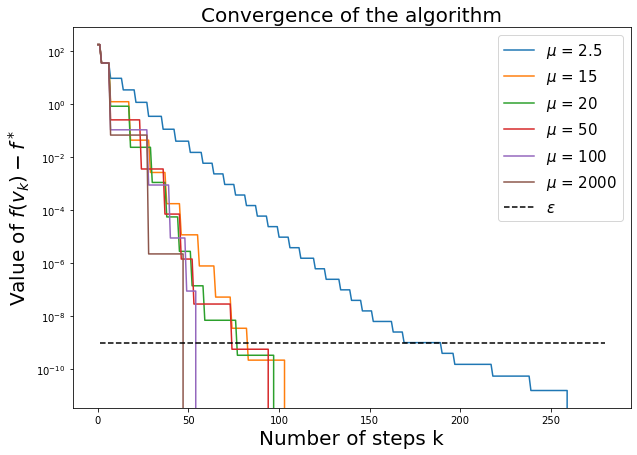

In [159]:
fig = plt.figure(figsize=(10, 7))

L=-np.inf
for mu in [2.5, 15, 20, 50, 100, 2000] :
    V = barr_method(Q, p, A, b, v0=np.zeros(n), eps=eps, mu=mu) 
    if len(V)>L :
        L = len(V)

    x = []
    for v in V : 
        x.append(f0(Q, p, v))
    print(len(V))
    print("Value of the optimum : {:.4f}".format(f0(Q, p, V[-1])))
    plt.plot(np.array(x)-np.min(x))
    plt.yscale("log")
    plt.xlabel("Number of steps k", fontsize=20)
    plt.ylabel("Value of $f(v_k) - f^*$", fontsize=20)
    plt.title("Convergence of the algorithm", fontsize=20)

plt.hlines(eps, 1, L, linestyles='--', color="k", label="eps")
plt.legend(["$\mu$ = {}".format(mu) for mu in [2.5, 15, 20, 50, 100, 2000]]+["$\epsilon$"], fontsize=15)
plt.show()

Let's check if our implementation of Newton's method is correct, using `cvxpy` library. 

In [160]:
v = cp.Variable(n)
prob = cp.Problem(cp.Minimize(cp.quad_form(v, Q) + p.T @ v),
                 [A @ v <= b])
print("Value of the optimum : {:.4f}".format(prob.solve()))
print("Optimal point :", v.value)
print("Optimal point obtained with a log-barrier method :", V[-1])

Value of the optimum : -182.2625
Optimal point : [-1.48163596 -2.24122506  0.08928414 -1.60312274 -1.42664813 -2.04950161
 -1.26367456 -0.67457764 -1.13191262 -1.64197554]
Optimal point obtained with a log-barrier method : [-1.48163596 -2.24122506  0.08928414 -1.60312273 -1.42664813 -2.04950161
 -1.26367456 -0.67457764 -1.13191262 -1.64197554]


We can see above that our implementation is correct.

<b> What is a good choice for $\mu$ ? </b>

Heuristically, an appropriate choice for $\mu$ would be a $\mu \geqslant 20$. Indeed, for $\mu \geqslant 20$, the total number of steps of the method doesn't change and gives us a linear convergence with a high slope.

\subsection*{Recovering $w^*$ from $v^*$}

We want to recover $w^*$ from $v^*$. First, let's take a look at cvxpy solution.
We have a spare solution as expected.

Value of the optimum : 340.8627


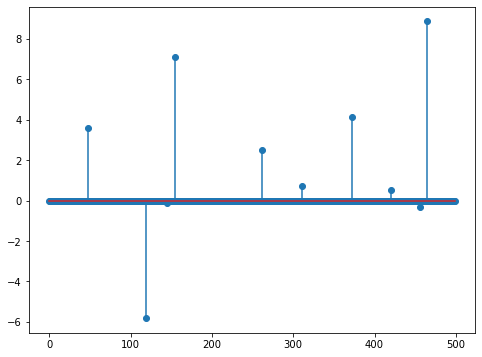

In [129]:
w = cp.Variable(d)
prob = cp.Problem(cp.Minimize(cp.norm2(y - X@w)**2 + Lambda*cp.norm1(w)),
                 )
print("Value of the optimum : {:.4f}".format(prob.solve(solver=cp.ECOS)))
fig = plt.figure(figsize=(8, 6))
plt.stem(w.value)
plt.show()

How can we recover $w^*$ from $v^*$ ?

We have the following relation between $w^*$ and $v^*$ from the primal feasibility and computation of dual : 

\begin{equation} v^* = Xw^* - y \end{equation}

From the extended KKT conditions, we have : 

$$ 0 \in \partial_{w_i} L(w^*, u^*, v^*) = \lambda \cdot \partial_{w_i^*}{\|w^*\|_1} + (X^Tv^*)_i$$

Morover, we have $$\lambda \cdot \partial_{w_i^*}{\|w^*\|_1} = -(X^Tv^*)_i$$

where 

\begin{equation*}
\partial_{x_i^*}{\|x\|_1} =
\begin{cases}
    1 & \text{ if } x_i > 0 \\
    -1 & \text{ if } x_i < 0 \\
    [-1, 1] & \text{ if } x_i = 0
\end{cases}
\end{equation*}

Hence, $$w_i^* < 0 \text{ if }(X^Tv^*)_i = \lambda  $$
$$w_i^* > 0 \text{ if }(X^Tv^*)_i = -\lambda  $$
$$w_i = 0 \text{ if } (X^Tv^*)_i \in (-\lambda, \lambda) $$

Hence, we're searching for a $w^*$ such that $w^* = X^+(v^* + y)$ and the previous conditions on the signs hold.

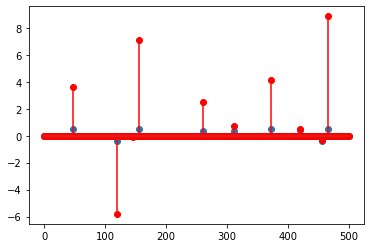

In [156]:
V = barr_method(Q, p, A, b, v0=np.zeros(n), eps=1e-9, mu=150)
signs = np.zeros(d)
signs[np.isclose(X.T@V[-1], Lambda)] = -1
signs[np.isclose(X.T@V[-1], -Lambda)] = +1
w_star = np.linalg.pinv(X)@((V[-1]+y))
plt.stem(w_star*np.abs(signs))
stem_color = 'r'  # blue
marker_color = 'r'  # red
plt.stem(w.value, linefmt=f'{stem_color}', markerfmt=f'{marker_color}o')
plt.show()

We recover the signs of the lasso optimizer but not the true values.